In [60]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam

%matplotlib inline 

# Metastatic Tumor Detection with CNN

## Overview

- The 96x96 images of this dataset are small part of H&E pathological scans of lymph nodes. The H&E shows the cell nuclei and structure. The lymph nodes scans are often used to diagnose metastasis as that's how cancer cells spread to other organs.

- This is a binary classification problem because the scan can either contain metastatic tumor or non cancerous. The goal of this project is to build a CNN model that can predict if the histology scan contain tumorous tissues.

- The dataset is downloaded from Kaggle as a competition.

## EDA

### Import data

Let's import the training data label.

In [23]:
#Import training labels
train_lab = pd.read_csv('train_labels.csv')
train_dir = "train/"

### Inspect data

There are 220025 training images. This is a large number of training data.

In [15]:
#Inspect training data
print("Number of training images: ",train_lab.shape[0])

train_lab.head()

Number of training images:  220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


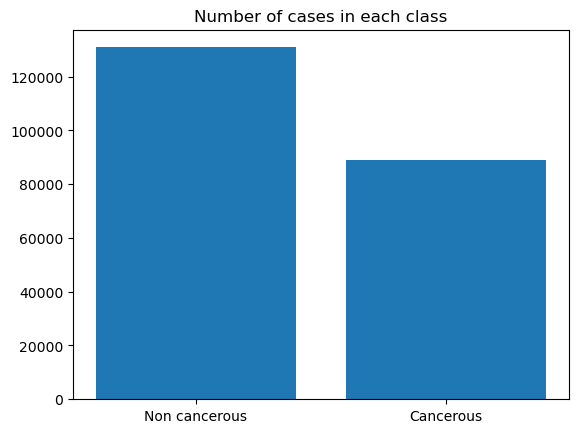

In [22]:
# Number of images in each class
Neg_num=sum(train_lab['label']==0)
Pos_num=sum(train_lab['label']==1)

x = np.array(["Non cancerous", "Cancerous"])
y = np.array([Neg_num, Pos_num])

plt.bar(x,y)
plt.title("Number of cases in each class")
plt.show()

We see that the number of non cancerous images is larger than the cancerous images. This could cause training data imbalance. I will resolve this problem later on.

### Visualize images

<function matplotlib.pyplot.show(close=None, block=None)>

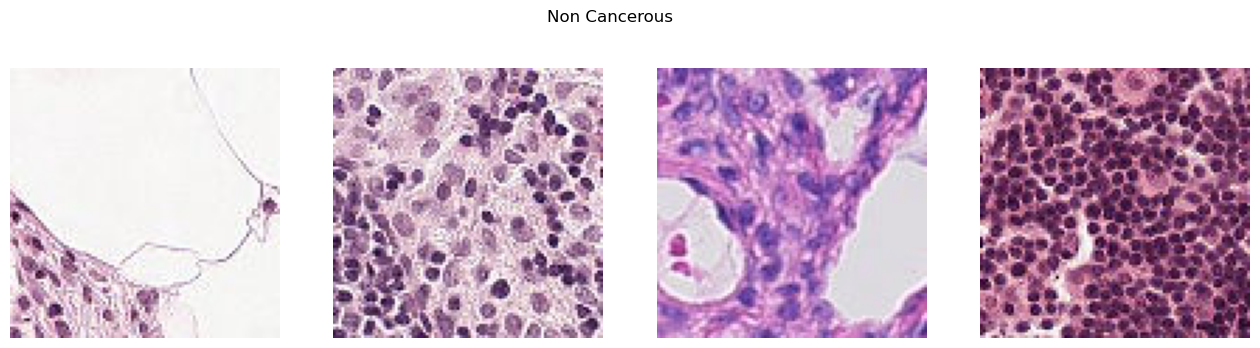

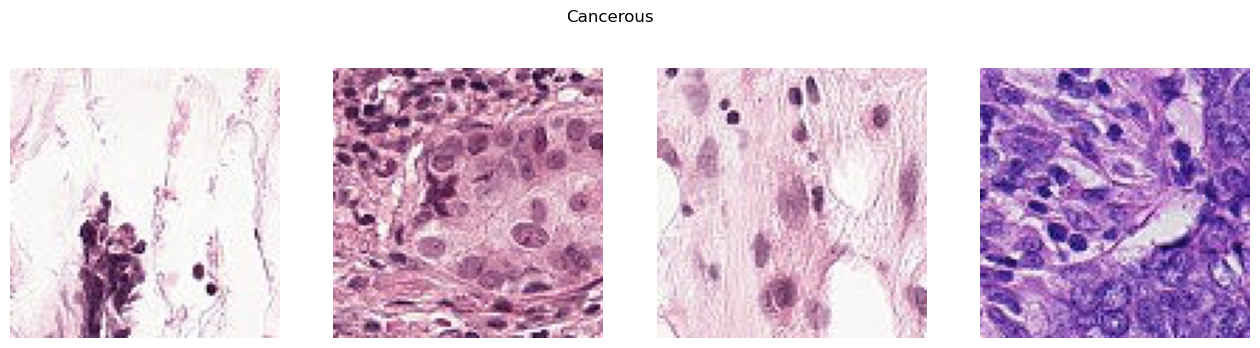

In [31]:
#Show example images
#Non cancerous
lab1=train_lab[train_lab['label'] == 0]['id'][:4]
plt.figure(figsize=(16, 4))
for i,ID in enumerate(lab1):
    path=os.path.join(train_dir, ID + '.tif')
    img=Image.open(path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Non Cancerous")
plt.show

#Cancerous
lab2=train_lab[train_lab['label'] == 1]['id'][:4]
plt.figure(figsize=(16, 4))
for i,ID in enumerate(lab2):
    path=os.path.join(train_dir, ID + '.tif')
    img=Image.open(path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Cancerous")
plt.show

A quick look of some cancer and non cancer images.

To a person without expertise in the medical and cancer biology field, it would be hard to separate the cancerous and non cancerous images. 

Hopefully my model will be able to predict this with high accuracy.

### Data cleaning

I noticed that the number of non cancer images are higher than cancer images. This could cause data imbalance and reduce model performance.

Therefore, I randomly select 80000 images from the cancer and non cancer sets. This would make the ratio between 2 classes 1. I also decide to reduce the number of training data because the whole training set is quite large and my computer can't facilitate running that large sample size.

In [32]:
#Reduce the training set size to balance the class
pos_lab = train_lab[train_lab['label'] == 1]
neg_lab = train_lab[train_lab['label'] == 0]

#SELECT 80000 images for each class
pos_lab = pos_lab.sample(n=80000, random_state=21)
neg_lab = neg_lab.sample(n=80000, random_state=21)

train_df = pd.concat([pos_lab, neg_lab])

# Shuffle
train_df = train_df.sample(frac=1, random_state=21).reset_index(drop=True)

I will also import the images and split the training set into training and validation sets.

Validation set will have 25% of the original data set.

The following code will import the images and convert them to 3 channels (RBG) images.

In [35]:
#Image preprocessing
#Update image labels to match actual labels
train_df['id'] = train_df['id'].apply(lambda x: x + '.tif')
train_df['label'] = train_df['label'].astype(str)

#Select batch size
batch_size = 64
img_size = (96, 96)

#Reserve 25% of the training data for validation
train_datagen = ImageDataGenerator(validation_split=0.25)

#Split training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True)


Found 120000 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.


## Model architecture

I choose to build a Convolutinal Neural Network (CNN) because of its effeciency in proccessing and predict images.

My model will have an input size of 96x96x3. This is the input images size of 96x96 and 3 color channels.

The first layer is a rescaling layer, in which pixel values are rescaled from (0,255) to (0,1). This will help the model be more efficient.

There are 3 Convolutional layers following by Max pooling layers. The Convolutional layers will extract important features from images and the max pooling will help reduce feature maps dimension for the next steps.

Then the feature map is flattened and travels through a dense layer of 128 filters.

I also add a Drop out layer with masking rate of 0.25. This would randomly change weights of 25% of the last layer to 0. The drop out layer will help reduce overfitting risk.

The output layer is a dense layer with activation fucntion sigmoid giving the probability of image being cancerous.

In [41]:
# Model Architecture
Model = Sequential([
    Input(shape=(96, 96, 3)), # The input image dimension 96x96 by 3 colors channel (R,B,G)
    Rescaling(1./255), # Rescale inputs from (0,255) to (0,1)
    Conv2D(16, (3, 3), activation='relu'), # Convolutional layer with 16 filters of size 3x3
    MaxPooling2D(2, 2), # Max pool 2x2
    Conv2D(32, (3, 3), activation='relu'), # Convolutional layer with 32 filters of size 3x3
    MaxPooling2D(2, 2), # Max pool 2x2
    Conv2D(64, (3, 3), activation='relu'), # Convolutional layer with 64 filters of size 3x3
    MaxPooling2D(2, 2), # Max pool 2x2
    Flatten(), # Flatten feature map to 1 dimension
    Dense(128, activation='relu'), # Dense layer with 126 neurons
    Dropout(0.25), # Drop out layer
    Dense(1, activation='sigmoid') # Output layer with sigmoid activation fuction
])

# Summary of Model
Model.summary()

2024-09-14 13:12:08.719024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        1

## Training model

I decide to optimize the model using adam optimizer with initial learning rate of 0.0001. Adam optimizer will help the model converge faster because it is an adaptive learning rate optimizer.

The loss function is selected to be binary cross entropy. This is appropriate for my data because it's a binary classification problem. 

I also use early stopping for my model. My model would stop the epoch when the validation loss doesn't decrease significantly after 1 epoch. After stopping, the model will use the weights from the previous best epoch. I decide to use early stopping because this is a large data set to train and my computater capacity isn't great. Early stopping also prevent the model from overfitting.

Now let's train the model.

In [44]:
# Compile the model
Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
ES = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model
history = Model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[ES])

Epoch 1/10
1875/1875 [==============================] - 822s 438ms/step - loss: 0.4515 - accuracy: 0.7954 - val_loss: 0.4077 - val_accuracy: 0.8213
Epoch 2/10
1875/1875 [==============================] - 744s 397ms/step - loss: 0.3784 - accuracy: 0.8357 - val_loss: 0.3496 - val_accuracy: 0.8473
Epoch 3/10
1875/1875 [==============================] - 744s 397ms/step - loss: 0.3287 - accuracy: 0.8599 - val_loss: 0.3536 - val_accuracy: 0.8484


## Results

The model stops its training after 3 epoch. We can see that the validation loss stops increasing after the second epoch. Therefore, early stopping helps save training time and prevent overfitting.

The model training and validation accuracy are pretty high. The losses are also low.

Let's plot and see how the model performs after each epoch.

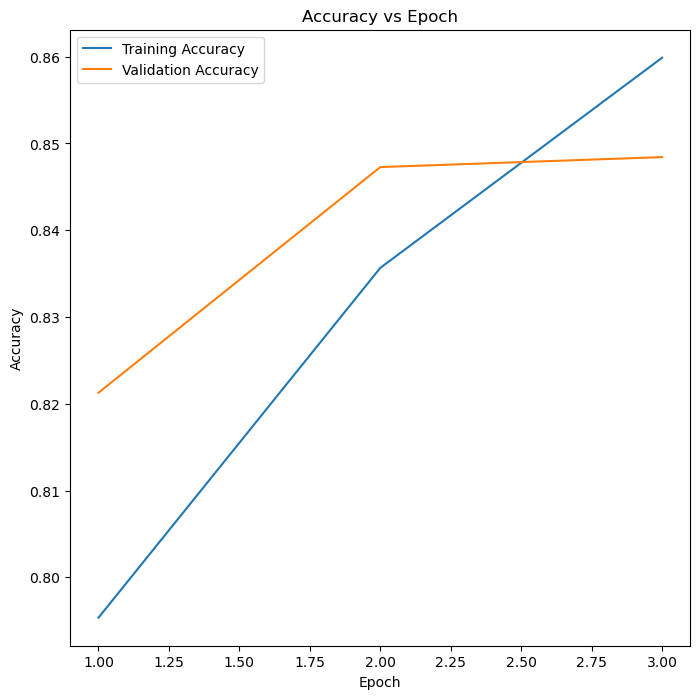

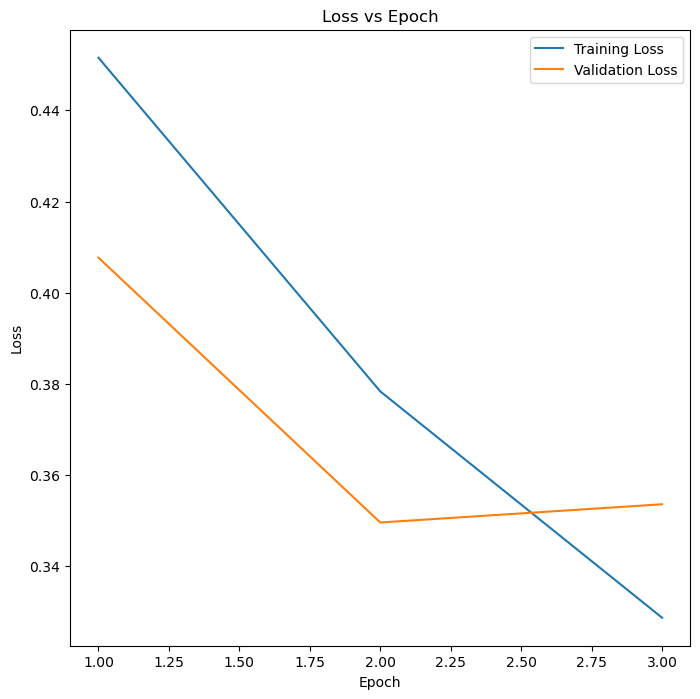

In [58]:
#Plot accuracy vs epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch_=[1,2,3]

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_acc, label="Training Accuracy")
plt.plot(epoch_,val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Plot loss vs epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_loss, label="Training Loss")
plt.plot(epoch_,val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

We see that the model increases its training and validation at the second epoch. However, at the third epoch, the validation accuracy doesn't increase much while the training accuracy still increases. The validation loss increases from second to third epoch. This suggests that the model has converged and have a risk of overfitting if it continues to be trained.

Therefore, the model converges at the second epoch and being stopped at epoch 3.

The has a great performance as the validation accuracy is 0.8473. This indicates the model could detect metatstatic cancer from H&E scans well.

## Improve model architecture

Let's see if I can improve the model performance by changing the model architecture. 

I add batch normalization after each convolutional layer. This Batch normalization layer will normalize the output feature maps from convolutional layers. Adding batch normalization can help reduce internal covariate shift, improve model stability, as well as speeding up the training.

In [61]:
# Model Architect with batch normalization
Model1 = Sequential([
    Input(shape=(96, 96, 3)), # The input image dimension 96x96 by 3 colors channel (R,B,G)
    Rescaling(1./255), # Rescale inputs from (0,255) to (0,1)
    Conv2D(16, (3, 3), activation='relu'), # Convolutional layer with 16 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Conv2D(32, (3, 3), activation='relu'), # Convolutional layer with 32 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Conv2D(64, (3, 3), activation='relu'), # Convolutional layer with 64 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Flatten(), # Flatten feature map to 1 dimension
    Dense(128, activation='relu'), # Dense layer with 126 neurons
    Dropout(0.25), # Drop out layer
    Dense(1, activation='sigmoid') # Output layer with sigmoid activation fuction
])

# Summary of Model
Model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 32)      

In [62]:
# Compile the model
Model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
ES = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model
history1 = Model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[ES])

Epoch 1/10
1875/1875 [==============================] - 1157s 616ms/step - loss: 0.3975 - accuracy: 0.8327 - val_loss: 0.3589 - val_accuracy: 0.8479
Epoch 2/10
1875/1875 [==============================] - 1139s 607ms/step - loss: 0.3091 - accuracy: 0.8729 - val_loss: 0.5655 - val_accuracy: 0.7933


The model has stopped at the second epoch. We can see that just after 1 epoch, the model already acheived a high validation accuracy and low loss. 

The model stopped at the second epoch because the validation loss starts to increase.

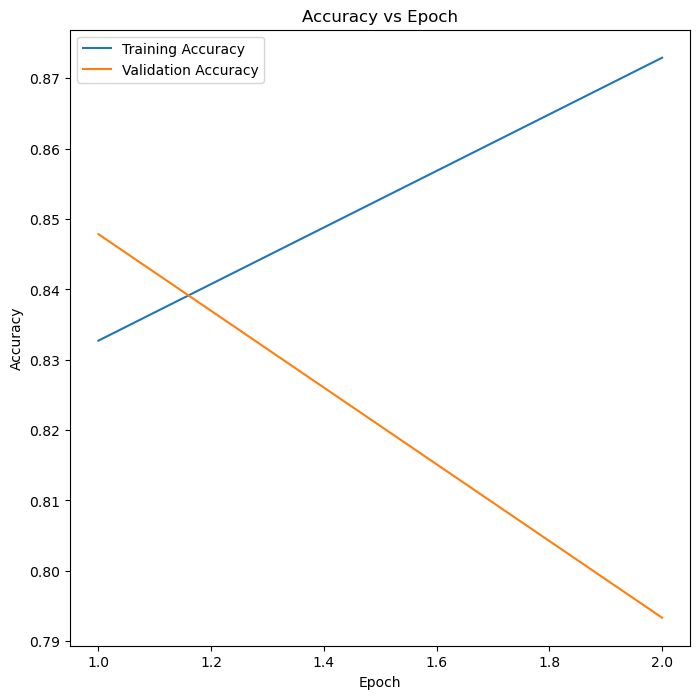

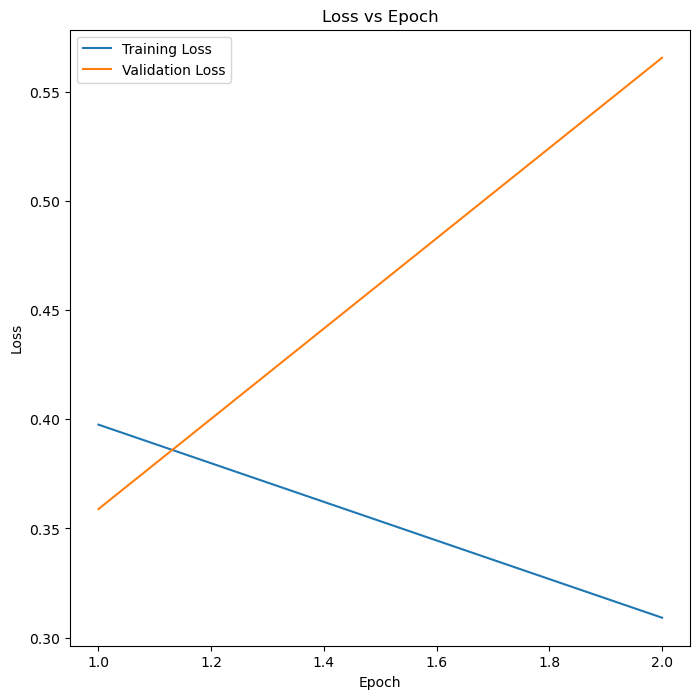

In [63]:
#Plot accuracy vs epoch
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
epoch_=[1,2]

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_acc, label="Training Accuracy")
plt.plot(epoch_,val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Plot loss vs epoch
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_loss, label="Training Loss")
plt.plot(epoch_,val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

We can see that after the first epoch, the validation accuracy decreases while the training accuracy increases. Also, the validation loss starts to increase at the second epoch. This suggests that the model has converged at the first epoch.

The batch normalization layers help speed up the training process as the model coverges at the first epoch. However, the validation accuracy and loss is the same to the first model without batch normalization. So I think adding batch normalization didn't improve the model performance in this case.

Therefore, I will select my original model as my final model.

## Test data prediction

Let's predict the test data and submit to Kaggle to receive a final score

In [66]:
# Get Test data
test_dir = "test/"
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=img_size,
    batch_size=1,
    class_mode=None,
    shuffle=False)


# Predict on test data
pred = Model.predict(test_generator, steps=test_generator.samples)


Found 57458 validated image filenames.
57458/57458 [==============================] - 382s 7ms/step


In [70]:
# Export submission file
test_id=[ids[:-4] for ids in os.listdir(test_dir)]
pred_lab=(pred > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': test_id,
    'label': pred_lab})

# Export
submission_df.to_csv('submission.csv', index=False)

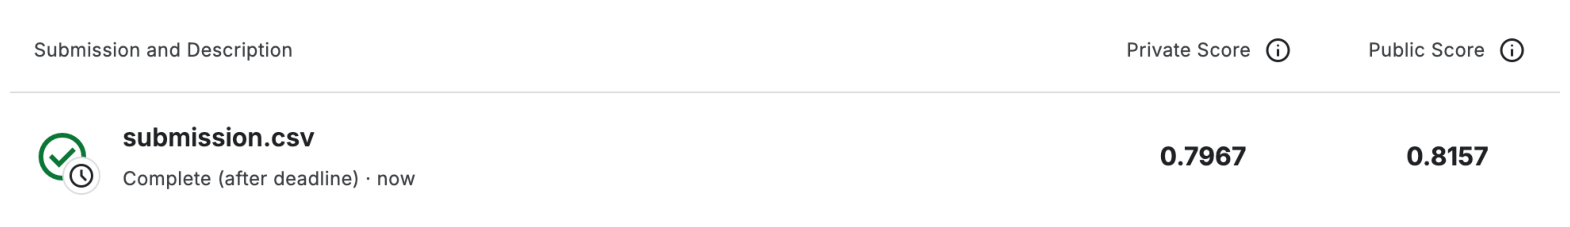

In [77]:
# Show score on Test set
img = Image.open('Test_score.png')

plt.figure(figsize=(20, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

After submitting my prediction of the test data to Kaggle, I received a test score of 0.82.

## Discussion

My model performs pretty well with this data set. The multiple convolutional layers have extracted important features from the images to identify metastatic cancer. I think by reducing the training dataset so that the number of cancer and non cancer images are the same help with model performance. Reducing training data also help speed up the training process. I also split training data into mini batches of 64 images to speed up the training.

Adding batch normalization layers helped speed up the training process but it didn't imporve model performance. I think this is because the images are already normalized to have range of 0-1 in the input layer. Because the added layers didn't improve performance, I decided to select my first model as my best model.

My model achieved a test score of 0.82. This is a pretty good accuracy but the model can still be improved in the future. The model can have a larger number of filters and convolutional layers. It can also have a more complex architecture like VGG Net or Inception Net. 